In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os


logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
n = 200
K=14
noise=0.04
factor = 0.3
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=factor,
                                      noise=noise)

In [4]:
project_dir = "../data/circles"
os.makedirs(project_dir, exist_ok=1)

In [5]:
noisy_circles.shape

(200, 2)

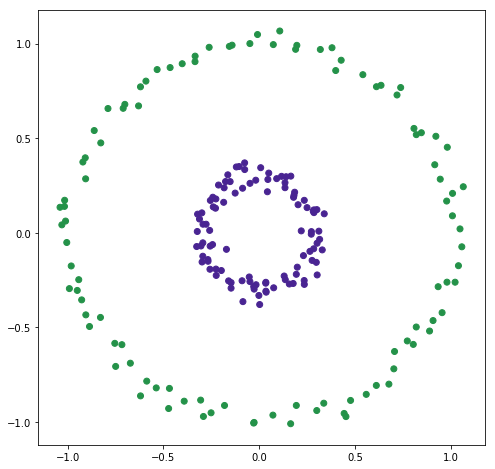

In [6]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [7]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1))
linear_models.fit(noisy_circles)

In [8]:
def make_local_nonodr_lines_animation(mean_models, data, c, pth, bandwidths, range_pct=0.1, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(bandwidths), tag="odr_lines")
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    os.makedirs(pth, exist_ok=1)
    for bandwidth in bandwidths:
        with timelog:
            print(bandwidth)
            kernel_cb = kernel(bandwidth=bandwidth)
            figure = plt.figure()
            linear_params_cb = linear_models.transform(data,r=kernel_cb.support_radius(),weighted=True,distance_transform=kernel_cb)
            linear_params_mean = linear_params_cb[:,2:]
            linear_params_vecs = linear_params_cb[:,:2]
            span = ((-0.2,0.2,0.04),)
            for i in range(data.shape[0]):
                pt = sublinear_project_vectorized(data[i:i+1], linear_params_vecs[i:i+1]) - data[i:i+1]
                line = sublinear_space(linear_params_vecs[i:i+1], span) + linear_params_mean[i:i+1]
                plt.plot(line[:,0], line[:,1])
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title(str(bandwidth))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])

            plt.savefig(os.path.join(pth, "bandwidth_{:010.5f}.png".format(bandwidth)))

NameError: name 'lm' is not defined

In [ ]:
fig_dir_lines = os.path.join(project_dir, "odr_various_bandwidth")
make_local_odr_lines_animation(linear_models, noisy_circles, c, fig_dir_lines, 
    np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), 
                    np.linspace(0.3,1,20,endpoint=False), 
                    np.linspace(1,5,20,endpoint=False))),
                               kernel=KERNEL
)

In [ ]:
def make_local_odr_projections_animation_k(linear_models, data, c, pth, ks, range_pct=0.1, grid_steps=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(ks), tag="odr_projections_k", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec().fit(grid)
    grid = gridder.transform(grid)
    projections = np.zeros(grid.shape)
    
    os.makedirs(pth, exist_ok=1)
    for k in ks:
        with timelog:
            kernel_kb = kernel(bandwidth="knn")        
            figure = plt.figure()
            linear_params_grid = linear_models.transform(grid, k=k, weighted=True, distance_transform=kernel_kb)
            linear_params_mean = linear_params_grid[:,2:]
            linear_params_vecs = linear_params_grid[:,:2]
            for i in range(grid.shape[0]):
                projections[i] = sublinear_project_vectorized(grid[i:i+1] - linear_params_mean[i:i+1], linear_params_vecs[i:i+1]) + linear_params_mean[i:i+1]- grid[i:i+1]
            plt.quiver(grid[:,0], grid[:,1], projections[:,0], projections[:,1], scale=10)
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title("k {:05d}".format(k))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "k_{:05d}.png".format(k)))    
    

In [ ]:
fig_dir_projections_k = os.path.join(project_dir, "odr_projections_various_k")
make_local_odr_projections_animation_k(linear_models, noisy_circles, c, fig_dir_projections_k,
                                     np.arange(3,K),
                                     kernel=KERNEL
                                    )

In [ ]:
def make_local_odr_projections_animation(linear_models, data, c, pth, bandwidths, range_pct=0.1, grid_steps=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(bandwidths), tag="odr_projections", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec().fit(grid)
    grid = gridder.transform(grid)
    projections = np.zeros(grid.shape)
    
    os.makedirs(pth, exist_ok=1)
    for bandwidth in bandwidths:
        with timelog:
            kernel_cb = kernel(bandwidth=bandwidth)        
            figure = plt.figure()
            linear_params_grid = linear_models.transform(grid, r=kernel_cb.support_radius(), weighted=True, distance_transform=kernel_cb)
            linear_params_mean = linear_params_grid[:,2:]
            linear_params_vecs = linear_params_grid[:,:2]
            for i in range(grid.shape[0]):
                projections[i] = sublinear_project_vectorized(grid[i:i+1] - linear_params_mean[i:i+1], linear_params_vecs[i:i+1]) + linear_params_mean[i:i+1]- grid[i:i+1]
            plt.quiver(grid[:,0], grid[:,1], projections[:,0], projections[:,1], scale=10)
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title(str(bandwidth))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "bandwidth_{:010.5f}.png".format(bandwidth)))

In [ ]:
fig_dir_projections = os.path.join(project_dir, "odr_projections_various_bandwidth")
make_local_odr_projections_animation(linear_models, noisy_circles, c, fig_dir_projections,
                                     np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), 
                                                     np.linspace(0.3,1,20,endpoint=False), 
                                                     np.linspace(1,5,20,endpoint=False))),
                                     kernel=KERNEL
                                    )
plt.close()


In [ ]:
imgs2video(os.path.join(fig_dir_lines,"*.png"),
           os.path.join(fig_dir_lines,"out.mp4"), 10)
imgs2video(os.path.join(fig_dir_projections,"*.png"), 
           os.path.join(fig_dir_projections,"out.mp4"), 10)

In [ ]:
from IPython.display import Markdown as md
def video_html(src):
    return '''<video controls src="{}" type="video/mp4"/>'''.format(src)
md(video_html(os.path.join(fig_dir_lines, "out.mp4")) +
   video_html(os.path.join(fig_dir_projections, "out.mp4")))

In [7]:
def make_odr_iterprojections_animation(linear_models, data, c, pth, bandwidth, range_pct=0.1, grid_steps=100, iterations=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iterations, tag="odr_iterprojections", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(noisy_circles, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec()
    grid = gridder.fit_transform(grid)
    projections = grid.copy()
    kernel_cb = kernel(bandwidth=bandwidth)

    os.makedirs(pth, exist_ok=1)
    for i in range(iterations):
        with timelog:
            figure = plt.figure()
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.scatter(projections[:,0], projections[:,1],c='r',s=0.1)
            plt.title("iteration_{:05d}".format(i))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "iteration_{:05d}.png".format(i)))
            linear_params_grid = linear_models.transform(projections, r=kernel_cb.support_radius(), weighted=True, distance_transform=kernel_cb)
            err_pts = np.any(np.isnan(linear_params_grid), axis=1)
            logger.info("linear odr undefined at {} pts".format(err_pts.sum()))
            good_pts = np.logical_not(err_pts)
            projections, linear_params_grid = projections[good_pts], linear_params_grid[good_pts]
            linear_params_mean = linear_params_grid[:,2:]
            linear_params_vecs = linear_params_grid[:,:2]
            for i in range(projections.shape[0]):
                projections[i:i+1] += sublinear_project_vectorized(projections[i:i+1] - linear_params_mean[i:i+1], linear_params_vecs[i:i+1]) + linear_params_mean[i:i+1]- projections[i:i+1]

NameError: name 'lm' is not defined

In [ ]:
BANDWIDTH = 0.192
N_STEPS = 100
fig_dir = os.path.join(project_dir, "odr_projections_iteration_b{:.4f}_g{:05d}".format(BANDWIDTH,N_STEPS))
make_odr_iterprojections_animation(linear_models, noisy_circles, c, fig_dir, BANDWIDTH, grid_steps=N_STEPS, kernel=KERNEL)
plt.close()

In [18]:
bandwidth = 0.8
K = 2
data = noisy_circles
range_pct = 0.1
kernel = KERNEL
grid_steps = 100

data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)
spans = np.stack([(-0.02, 0.02, 2j) for i in range(linear_models.model.m)])

grid = local_models.utils.get_global_grid(noisy_circles, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
projections = grid.copy()
kernel_cb = kernel(bandwidth=bandwidth)

for tls_shifted in local_models.algorithms.local_tls_shift_till_convergence(linear_models, projections, kernel=kernel_cb):
    pass
#tls_shifted_Jacobians, tls_shifted_means = local_models.linear_projections.transformate_data(tls_shifted, kernel_cb, linear_models,r=kernel_cb.support_radius())
#lines = local_models.linear_projections.make_local_odr_lines(tls_shifted_Jacobians, tls_shifted, spans)



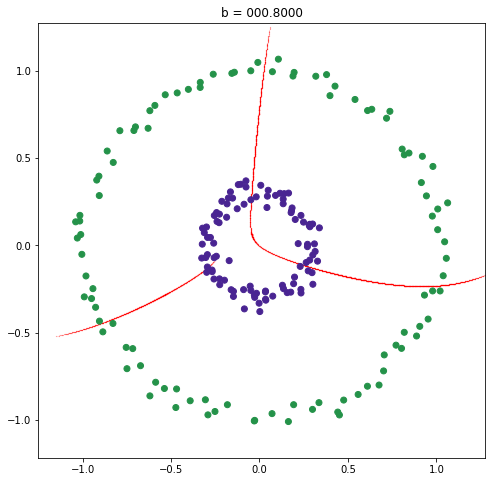

In [19]:
plt.scatter(tls_shifted[:,0],tls_shifted[:,1],c='r',s=0.01,marker='.')
#local_models.linear_projections.plt_local_odr_lines(lines)
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
local_models.linear_projections.plt_prettify("b = {:08.04f}".format(bandwidth), graph_bounds)
plt.savefig(os.path.join(project_dir, "converged_b_{:08.04f}.png".format(bandwidth)))

In [11]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
def detect_ridges(gray, sigma=3.0):
    hxx, hyy, hxy = hessian_matrix(gray, sigma)
    i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy)
    return i1, i2

def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

In [12]:
grid_steps = 1000

grid = local_models.utils.get_global_grid(noisy_circles, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)

kd = local_models.utils.kernel_density(grid, data, kernel_cb, metric='euclidean')

In [13]:
kd.shape

(1000000,)

In [14]:
im = gridder.inverse_transform(kd)

In [15]:
im.shape

(1, 1000, 1000)

In [16]:
graph_bounds

array([[-1.25001745, -1.21715903],
       [ 1.27435583,  1.27493739]])

In [17]:
graph_bounds.flatten()

array([-1.25001745, -1.21715903,  1.27435583,  1.27493739])

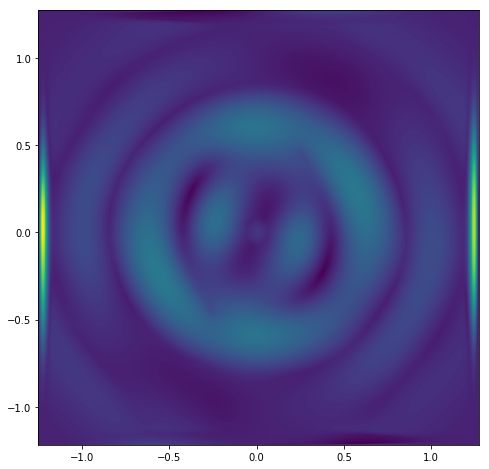

In [18]:
plt.imshow(detect_ridges(im[0].T, sigma=10)[0], origin='lower', extent=graph_bounds.T.flatten())

In [19]:
hess = hessian(im[0])

In [20]:
hess_eig = np.zeros(hess.shape)
for x in range(hess.shape[2]):
    for y in range(hess.shape[3]):
        lamb, v = np.linalg.eig(hess[:,:,x,y])
        lamb_argsort = lamb.argsort()
        hess_eig[:,:,x,y] = v[lamb_argsort]

In [21]:
hess_eig_x = hess_eig[0,:,:,:]
hess_eig_y = hess_eig[1,:,:,:]

In [22]:
gridded_hess_eig_x = gridder.transform(hess_eig_x)
gridded_hess_eig_y = gridder.transform(hess_eig_y)

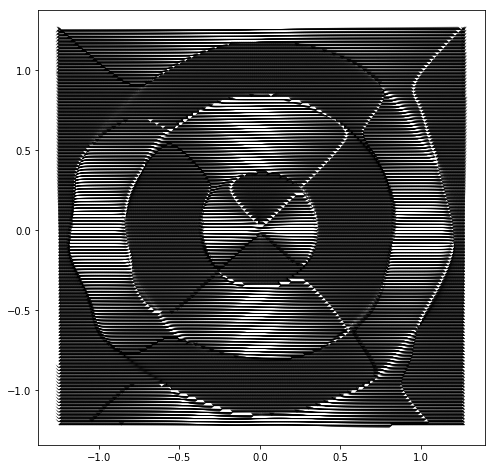

In [23]:
SR = SAMPLE_RATE = 8
plt.quiver(grid[::SR,0], grid[::SR,1], gridded_hess_eig_x[::SR,0], gridded_hess_eig_y[::SR,0], scale=100, headwidth=0, headlength=0)

In [24]:
grad_x, grad_y = np.gradient(im[0])

In [25]:
gridded_grad_x, gridded_grad_y = gridder.transform(np.expand_dims(grad_x,0)), gridder.transform(np.expand_dims(grad_y,0))

In [26]:
gridded_grad_x.shape

(1000000, 1)

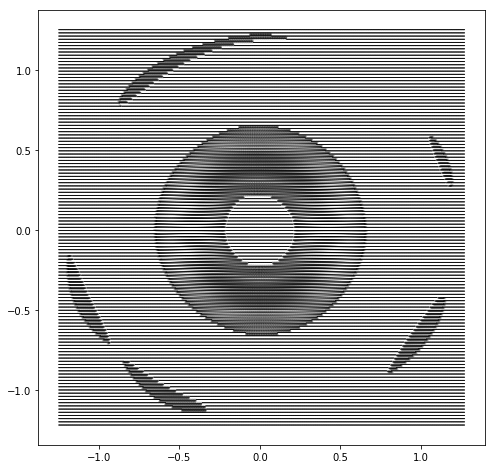

In [27]:
plt.quiver(grid[::SR,0], grid[::SR,1], gridded_grad_x[::SR], gridded_grad_y[::SR], scale=10, headwidth=0, headlength=0)

$$L_v^2 L_{uu} = L_x^2 L_{yy} - 2 L_x L_y L_{xy} + L_y^2 L_{xx}$$
$$L_v^2 L_{uv} = L_x L_y (L_{xx} - L_{yy})  - (L_x^2 - L_y^2) L_{xy}$$
$$L_v^2 L_{vv} = L_x^2 L_{xx} + 2 L_x L_y L_{xy} + L_y^2 L_{yy}$$

In [28]:
X = 0
Y = 1
def lv2luu(hess, grad):
    return (grad[X]**2 * hess[Y,Y] -
            2*grad[X]*grad[Y]*hess[X,Y] +
            grad[Y]**2*hess[X,X])
def lv2luv(hess, grad):
    return (grad[X]*grad[Y]*(hess[X,X] - hess[Y,Y]) -
            (grad[X]**2 - grad[Y]**2)*hess[X,Y])
def lv2lvv(hess, grad):
    return (grad[X]**2 * hess[X,X] +
            2*grad[X]*grad[Y]*hess[X,Y] +
            grad[Y]**2*hess[Y,Y])
    

In [29]:
def ridges(hess, grad, tol=0.1):
    luu, luv, lvv = list(map(lambda f: f(hess, grad), [lv2luu, lv2luv, lv2lvv]))
    creases = np.logical_and(np.abs(luv) < tol, luu**2 - lvv**2 > 0)
    ridges = np.logical_and(creases, luu < 0)
    valleys = np.logical_and(creases, luu > 0)
    return ridges, valleys

In [30]:
np.stack((grad_x, grad_y)).shape

(2, 1000, 1000)

In [46]:
im_ridges, im_valleys = ridges(hess, np.stack((grad_x, grad_y)), tol=5e-10)

In [47]:
im_ridges

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

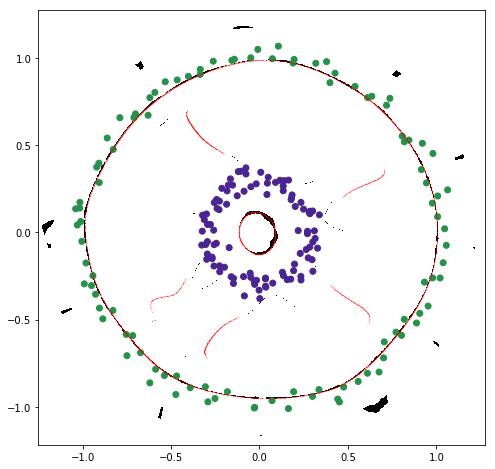

In [48]:
plt.imshow(np.logical_not(im_ridges.T), origin='lower', extent=graph_bounds.T.flatten(), cmap='gray', aspect='auto')
plt.scatter(noisy_circles[:,0], noisy_circles[:,1], c=cmap(c))
plt.scatter(tls_shifted2[:,0],tls_shifted2[:,1],c='r',s=0.01,marker='.')
plt.savefig(os.path.join(project_dir, "circles_hessian_ridges.png"))

In [49]:
#RANDOM MEAN SHIFT.... no need to use the original data as d in SUM(k*d)/SUM(k).... The optima correspond strictly to the density function!

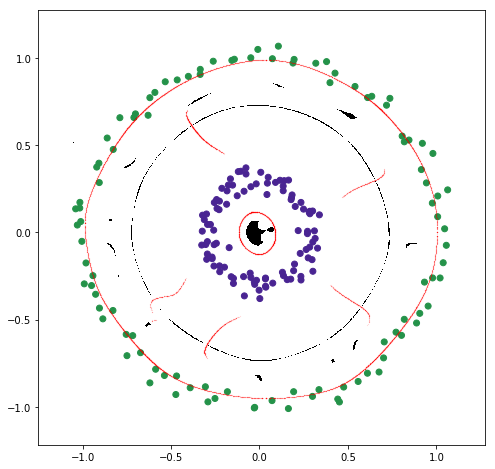

In [50]:
plt.imshow(np.logical_not(im_valleys.T), origin='lower', extent=graph_bounds.T.flatten(), cmap='gray', aspect='auto')
plt.scatter(noisy_circles[:,0], noisy_circles[:,1], c=cmap(c))
plt.scatter(tls_shifted2[:,0],tls_shifted2[:,1],c='r',s=0.01,marker='.')
plt.savefig(os.path.join(project_dir, "circles_hessian_valleys.png"))